# Gradient Boosting Regressor with 5 fold CV

In [1]:
# import the necessary libraries 
import import_ipynb
from iv_test_train_split import *
from v_utils import *

from sklearn.model_selection import KFold
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics

import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


import warnings
warnings.filterwarnings("ignore")


importing Jupyter notebook from iv_test_train_split.ipynb
price
<class 'pandas.core.series.Series'>
Int64Index: 4456 entries, 2594 to 4449
Series name: price
Non-Null Count  Dtype  
--------------  -----  
4456 non-null   float64
dtypes: float64(1)
memory usage: 69.6 KB
importing Jupyter notebook from v_utils.ipynb


In [2]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5, 6, 7, 10],
}

# Create the model and the GridSearchCV object
gb_model = GradientBoostingRegressor(random_state=447)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, n_jobs=-1, verbose=1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=447),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6, 7, 10],
                         'n_estimators': [100, 150, 200]},
             verbose=1)

In [3]:
# Print the best hyperparameters and the best score
print("Best hyperparameters: ", grid_search.best_params_)

Best hyperparameters:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}


In [2]:
 """
 @input:
 - X_train (numpy array or pandas DataFrame): Training data with features.
 - y_train (numpy array or pandas Series): Training data with target variable.
 - alpha (float): Quantile level for loss function.
 
 @output: Trained GBR model with the specified best hyperparameters and quantile level.

"""
def train_model(X_train, y_train, alpha, fold_index=None, n_folds=None):
    model = GradientBoostingRegressor(random_state=447, loss='quantile', 
                                      alpha=alpha, n_estimators=200, learning_rate=0.05,
                                      max_depth=5, max_features='auto')
    model.fit(X_train, y_train)
    return model


In [3]:
# Train a default GradientBoostingRegressor model

n_estimators = 200
learning_rate = 0.05
max_depth = 5
max_features = 'auto'

rc_model = GradientBoostingRegressor(random_state=447, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, max_features=max_features)
rc_model.fit(X_train, y_train)

# y pred test
rc_predict = rc_model.predict(X_test)

In [4]:
# Train lower and upper bound models for 0.5 quantile level
lower_bound_model50 = train_model(X_train, y_train, 0.25)
upper_bound_model50 = train_model(X_train, y_train, 0.75)

# Train lower and upper bound models for 0.8 quantile level
lower_bound_model80 = train_model(X_train, y_train, 0.1)
upper_bound_model80 = train_model(X_train, y_train, 0.9)

# Make point estimate and bound predictions for both quantile levels using the trained models
point_estimate = rc_model.predict(X_test)
lower_bound50 = lower_bound_model50.predict(X_test)
lower_bound80 = lower_bound_model80.predict(X_test)
upper_bound50 = upper_bound_model50.predict(X_test)
upper_bound80 = upper_bound_model80.predict(X_test)

In [5]:

# Concatenate actual target values and predictions for both quantile levels into dataframes
# convert point estimate, lower bound, upper bound back so it is not in log form
predictions50 = pd.concat([
    np.exp(y_test).reset_index(drop=True),
    pd.Series( np.exp(point_estimate), name='point_estimate'),
    pd.Series(np.exp(lower_bound50), name='lower_bound'),
    pd.Series( np.exp(upper_bound50), name='upper_bound')
], axis=1).round(3)

predictions80 = pd.concat([
    np.exp(y_test).reset_index(drop=True),
    pd.Series(np.exp(point_estimate), name='point_estimate'),
    pd.Series(np.exp(lower_bound80), name='lower_bound'),
    pd.Series(np.exp(upper_bound80), name='upper_bound')
], axis=1).round(3)

# print prediction LB and UP for level = 50%
predictions50.head()

,price,point_estimate,lower_bound,upper_bound
0,80.0,94.259,71.246,106.410
1,195.0,121.009,85.109,146.019
2,100.0,115.676,93.025,147.631
3,40.0,54.249,49.377,67.813
4,260.0,186.030,162.321,219.606


In [6]:
# print prediction LB and UP for level = 50%
predictions80.head()

,price,point_estimate,lower_bound,upper_bound
0,80.0,94.259,62.038,148.939
1,195.0,121.009,67.428,192.683
2,100.0,115.676,76.685,190.033
3,40.0,54.249,40.596,80.465
4,260.0,186.030,194.422,265.550


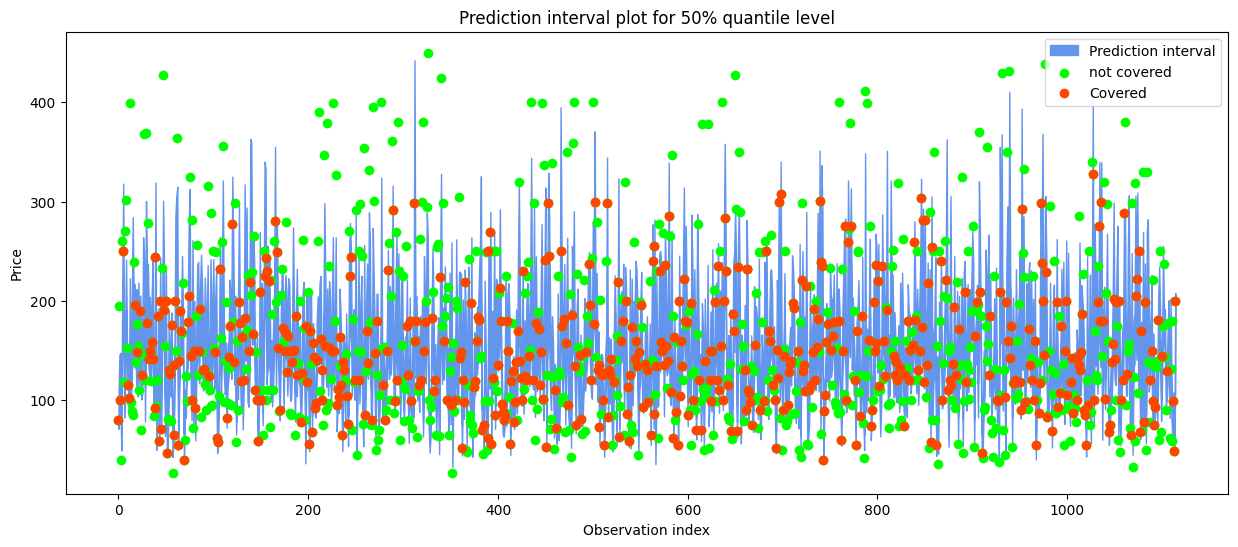

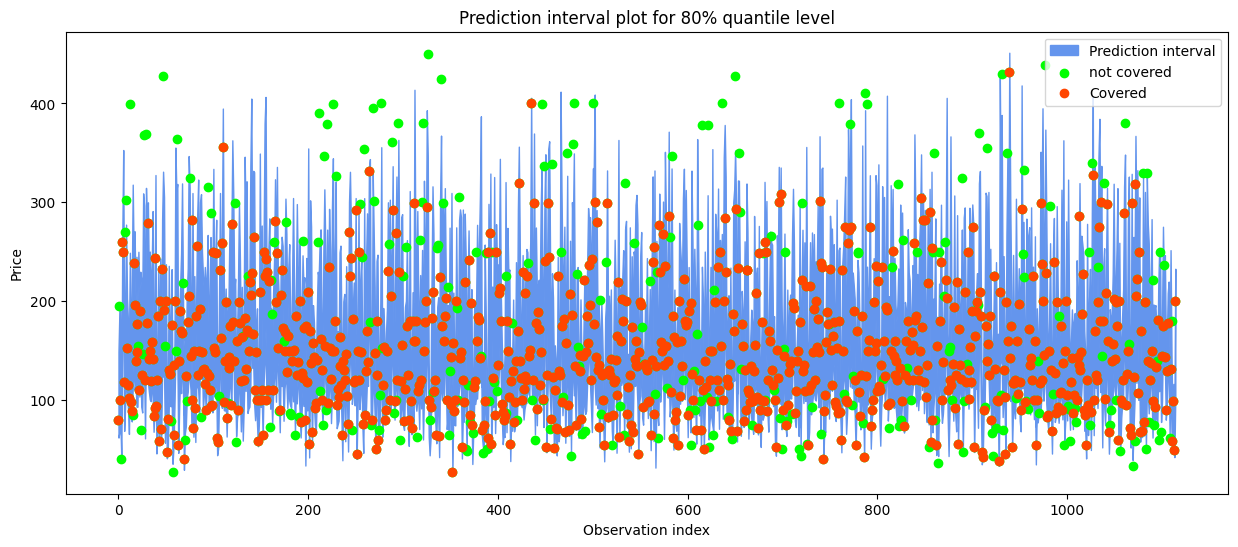

In [7]:
# actual vs predicted using prediction interval
plot_prediction_interval(y_test, lower_bound50, upper_bound50, 50)
plot_prediction_interval(y_test, lower_bound80, upper_bound80, 80)

In [8]:
"""
    @input:
    - X (pandas DataFrame): Data with features.
    - y (pandas Series): Data with target variable.
    - k (int): Number of folds for cross-validation.
    - alpha_levels (list): Quantile levels for loss function.
    
    @output: DataFrame containing metrics for each fold and their average values.
    
    @purpose: Cross-validate a Gradient Boosting Regressor model on the given data and calculate various metrics.
    
"""


def cross_validate_metrics(X, y, k=5, alpha_levels=[0.5, 0.8]):
    kf = KFold(n_splits=k, shuffle=True, random_state=447)
    
    metrics_results = []
    fold_num = 1
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Train models and make predictions
        rc_model = train_model(X_train, y_train, alpha=0.5)
        point_estimate = rc_model.predict(X_test)
        
        lower_bounds = {}
        upper_bounds = {}
        
        for alpha in alpha_levels:
            lower_bound_model = train_model(X_train, y_train, alpha=(1-alpha)/2)
            upper_bound_model = train_model(X_train, y_train, alpha=(1+alpha)/2)
            
            lower_bounds[alpha] = lower_bound_model.predict(X_test)
            upper_bounds[alpha] = upper_bound_model.predict(X_test)
        
        # Calculate metrics
        aic = AIC_gb(rc_model, X_train, y_train)
        mse = metrics.mean_squared_error(y_test, point_estimate)
        rmse = np.sqrt(mse)
        
        interval_metrics = {}
        for alpha in alpha_levels:
            pred_obj = np.column_stack((point_estimate, lower_bounds[alpha], upper_bounds[alpha]))
            interval_result = interval_score(pred_obj, y_test.values, alpha)
            
            interval_metrics[alpha] = {
                f'Interval Average Length ({alpha})': interval_result['summary'][1],
                f'Interval Score ({alpha})': interval_result['summary'][2],
                f'Coverage Rate ({alpha})': interval_result['summary'][3]
            }
        
        metrics_results.append({
            'Fold': fold_num,
            'AIC': aic,
            'MSE': mse,
            'RMSE': rmse,
            **{f"{key}": value for alpha, metrics_dict in interval_metrics.items() for key, value in metrics_dict.items()}
        })
        
        fold_num += 1
    
    # Create a DataFrame with the results
    results_df = pd.DataFrame(metrics_results)
    
    # Calculate average values and append them to the DataFrame
    avg_metrics = {
        'Fold': 'Average',
        'AIC': results_df['AIC'].mean(),
        'MSE': results_df['MSE'].mean(),
        'RMSE': results_df['RMSE'].mean(),
        **{key: results_df[key].mean() for key in results_df.columns if 'Interval' in key or 'Coverage' in key}
    }
    
    results_df = results_df.append(avg_metrics, ignore_index=True)
    
    # Round the values to 3 decimals
    results_df = results_df.round(3)
    
    # Set the DataFrame index to the 'Fold' column
    results_df.set_index('Fold', inplace=True)
    
    return results_df

In [9]:
results_gbr_df = cross_validate_metrics(X, y_log)

In [10]:
display(results_gbr_df)

,AIC,MSE,RMSE,Interval Average Length (0.5),Interval Score (0.5),Coverage Rate (0.5),Interval Average Length (0.8),Interval Score (0.8),Coverage Rate (0.8)
Fold,,,,,,,,,
1,-6244.034,0.103,0.322,0.383,0.799,0.471,0.756,1.152,0.753
2,-6472.896,0.120,0.346,0.378,0.841,0.444,0.767,1.214,0.741
3,-6434.898,0.106,0.325,0.390,0.794,0.482,0.778,1.134,0.768
4,-6361.738,0.112,0.335,0.377,0.836,0.417,0.773,1.210,0.724
5,-6295.653,0.100,0.316,0.380,0.788,0.435,0.790,1.159,0.763
Average,-6361.844,0.108,0.329,0.382,0.812,0.450,0.773,1.174,0.750


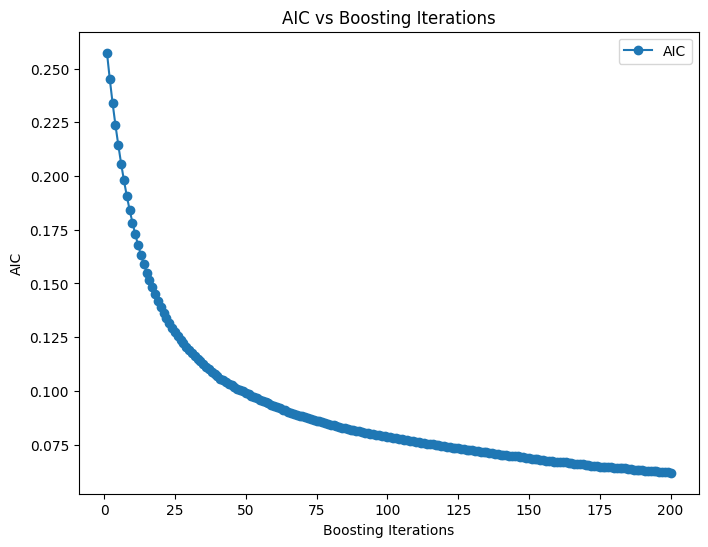

In [11]:
# in sample AIC plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rc_model.train_score_) + 1), rc_model.train_score_, marker='o', label="AIC")
plt.xlabel("Boosting Iterations")
plt.ylabel("AIC")
plt.title("AIC vs Boosting Iterations")
plt.legend()
plt.show()

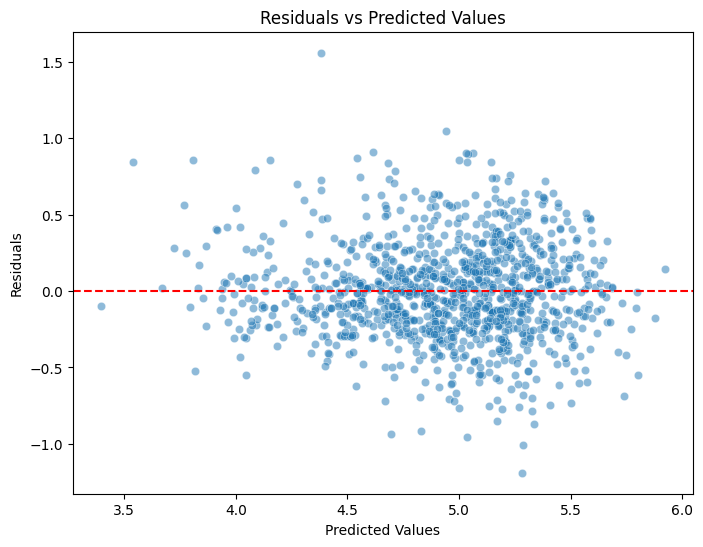

In [12]:
## Residual plot
plt.figure(figsize=(8, 6))
residuals = y_test - rc_predict
sns.scatterplot(x=rc_predict, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.show()


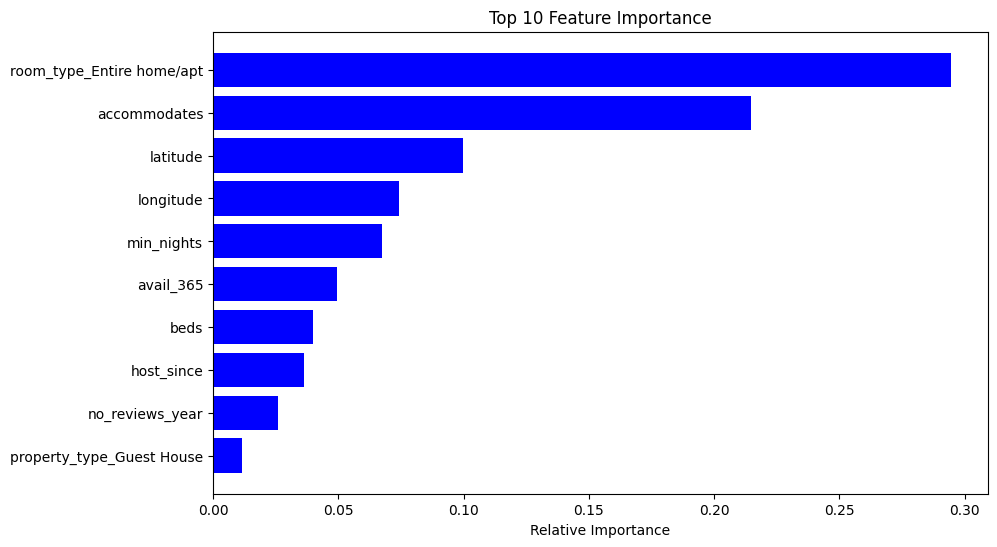

In [13]:
# Feature importance
plt.figure(figsize=(10, 6))
importance = rc_model.feature_importances_
indices = np.argsort(importance)[-10:]  # Select the indices of top 10 features
feature_names = X.columns

plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Top 10 Feature Importance')
plt.show()

In [15]:
# Extract the interval score columns from the DataFrame
interval_scores_df = results_gbr_df[['Interval Score (0.5)', 'Interval Score (0.8)']]

# Apply the exponential function to convert back log transform on interval score
interval_scores_exp_gbr = interval_scores_df.applymap(exp_func)
interval_scores_exp_gbr = interval_scores_exp_gbr.round(3)

In [16]:
interval_scores_exp_gbr.head(6)

,Interval Score (0.5),Interval Score (0.8)
Fold,,
1,2.223,3.165
2,2.319,3.367
3,2.212,3.108
4,2.307,3.353
5,2.199,3.187
Average,2.252,3.235
